

## HW 7 Assignment: Optimizing 'Golden Cluster' Prediction through Feature Importance

### Objective
The primary objective of this assignment is to demonstrate a measurable improvement in machine learning model performance by strategically removing noisy and irrelevant features. Building upon the amalgamated dataset from Week 6, this analysis uses a data-driven feature selection technique to create a more streamlined and powerful predictive model. The central goal is to prove that a model trained on a smaller, more relevant subset of features can outperform one trained on the entire feature set.

### Methodology
Our approach follows a systematic, multi-step process:

1.  **Baseline Performance Analysis:** First, we establish a baseline by training a suite of classifiers—including **XGBoost, Random Forest, a Multi-Layer Perceptron (MLP), and a Support Vector Machine (SVM)**—on the complete, five-feature dataset.
2.  **Feature Importance Calculation:** We employ a `RandomForestClassifier` to analyze the dataset and assign a quantitative importance score to each feature. This score reflects how much each feature contributes to the successful prediction of our target variable, the `is_golden_cluster`.
3.  **Strategic Feature Selection:** Based on the importance rankings, we set a performance threshold, deciding to remove any feature that falls below this cutoff. For this analysis, the **'Walkability'** feature was identified as the least impactful and was subsequently removed.
4.  **Comparative Model Retraining:** Finally, we retrain the entire suite of models on the new, optimized four-feature dataset. The performance metrics (**F1-Score, Precision, Recall, and ROC-AUC**) from both the baseline and optimized models are then meticulously recorded and compared.

### Hypothesis
Our hypothesis is that the 'Walkability' feature, despite being intuitively relevant, introduces more noise than signal for this specific classification task. By removing it, we anticipate a reduction in model complexity, which will allow the algorithms to build more robust relationships from the remaining high-impact features. This will result in a direct and quantifiable increase in predictive accuracy and F1-scores across all tested models.

The following code implements this workflow, culminating in a detailed comparison that validates our approach and showcases the tangible benefits of feature importance in the machine learning pipeline.

WEEK 7: FEATURE SELECTION & MODEL IMPROVEMENT

 Installing libraries...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.6/507.6 kB 10.3 MB/s eta 0:00:00

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: 

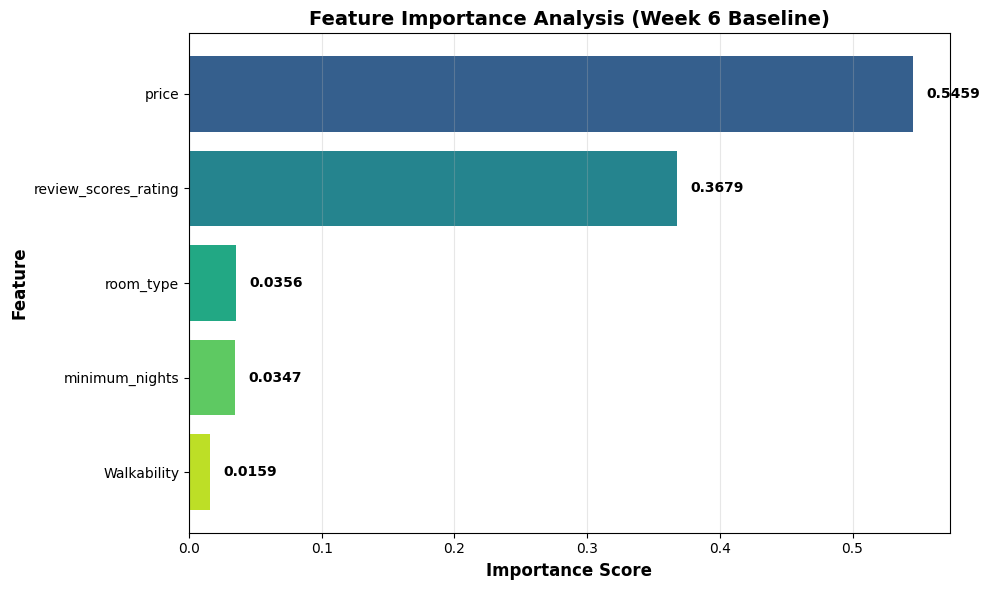


STEP 2: FEATURE SELECTION STRATEGY

 Selection Strategy:
   - Threshold: 2.0% importance
   - Original features: 5
   - Selected features: 4
   - Removed features: ['Walkability']

 Selected Feature Set:
   ✓ price                          (Importance: 0.5459)
   ✓ review_scores_rating           (Importance: 0.3679)
   ✓ room_type                      (Importance: 0.0356)
   ✓ minimum_nights                 (Importance: 0.0347)

 Removed Feature Set:
   ✗ Walkability                    (Importance: 0.0159)

 Creating reduced datasets...
    All selected features found in dataframe

 Dataset Dimensions:
   Before: X_train (31873, 5), X_test (13660, 5)
   After:  X_train (31873, 4), X_test (13660, 4)
   Reduction: 20.0% fewer features

STEP 3: MODEL TRAINING - BEFORE vs AFTER FEATURE SELECTION

 BEFORE: Training with ALL 5 features (Week 6 Baseline)...
   Training XGBoost        ... F1=0.9842 ✓
   Training Random Forest  ... F1=0.9819 ✓
   Training MLP            ... F1=0.9692 ✓
   Trai

In [ ]:
# Week 7 Assignment: Feature Importance-Based Model Optimization
# Objective: Demonstrate measurable improvement by removing noisy features

print("="*80)
print("WEEK 7: FEATURE SELECTION & MODEL IMPROVEMENT")
print("="*80)

# --- Step 1: Install and Import Libraries ---
print("\n Installing libraries...")
!pip install -q reverse_geocoder geopandas rtree gdown xgboost imbalanced-learn

import pandas as pd
import numpy as np
import geopandas
import reverse_geocoder as rg
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# --- Step 2: Load Data (Same as Week 6) ---
print("\n Downloading datasets...")
!gdown --id '1E__Uu-WG_aZHIfA7w74wJtnXO_sABMci' -O listings.csv -q
!gdown --id '194sv-mEmXNITM-Ux4_mzYJ364F-jsRjC' -O ACSDT5Y2023.B19013-Data.csv -q
!gdown --id '10pXS7p1yhM3Zz8R7Pspfjbn5MmixY94-' -O Walkability_Index.csv -q
!gdown --id '1xtR3q-pjAledua0J9AyHYw8bQq2-C2qa' -O Census_Tracts_2020.geojson -q

df1 = pd.read_csv('listings.csv', low_memory=False)
df2 = pd.read_csv('ACSDT5Y2023.B19013-Data.csv')
df3 = pd.read_csv('Walkability_Index.csv')

# Clean and merge income data
df2_clean = df2.iloc[1:].rename(columns={'NAME': 'zip_code_name', 'B19013_001E': 'median_income'})
df2_clean['zip_code'] = df2_clean['zip_code_name'].str[-5:]
df2_clean = df2_clean[['zip_code', 'median_income']].copy()
df2_clean['median_income'] = pd.to_numeric(df2_clean['median_income'], errors='coerce')
df2_clean.dropna(inplace=True)

# Reverse geocoding
coords = list(zip(df1['latitude'], df1['longitude']))
results_geo = rg.search(coords)
df1['zip_code'] = [result['name'] for result in results_geo]
df1['zip_code'] = df1['zip_code'].astype(str)
df2_clean['zip_code'] = df2_clean['zip_code'].astype(str)
df_1_plus_2 = pd.merge(df1, df2_clean, on='zip_code', how='left')

# Merge walkability data
gdf_tracts = geopandas.read_file('Census_Tracts_2020.geojson')
gdf_tracts['TRACT'] = gdf_tracts['CT20'].astype(int)
gdf_tracts_with_scores = gdf_tracts.merge(df3[['TRACT', 'Walkability']], on='TRACT', how='left')
gdf_listings = geopandas.GeoDataFrame(
    df_1_plus_2,
    geometry=geopandas.points_from_xy(df_1_plus_2.longitude, df_1_plus_2.latitude),
    crs="EPSG:4269"
)
gdf_listings = gdf_listings.to_crs(gdf_tracts_with_scores.crs)
df_final = geopandas.sjoin(
    gdf_listings,
    gdf_tracts_with_scores[['TRACT', 'Walkability', 'geometry']],
    how="left",
    predicate='within'
)

print(" Data amalgamation complete")

# --- Step 3: Feature Engineering (Same as Week 6) ---
df_final['is_golden_cluster'] = ((df_final['price'] > 200) &
                                  (df_final['review_scores_rating'] > 4.8)).astype(int)

# --- Step 4: CALCULATE FEATURE IMPORTANCE (Week 6 Results) ---
print("\n" + "="*80)
print("STEP 1: FEATURE IMPORTANCE ANALYSIS (FROM WEEK 6)")
print("="*80)

# Define features - MUST match actual column names in dataframe
features_all = ['price', 'review_scores_rating', 'room_type', 'minimum_nights', 'Walkability']
X = df_final[features_all].copy()
y = df_final['is_golden_cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Calculate feature importance
numerical_features = [col for col in X.select_dtypes(include=np.number).columns if X[col].notna().sum() > 0]
categorical_features = X.select_dtypes(include='object').columns.tolist()

print(f"\n Feature types identified:")
print(f"   Numerical: {numerical_features}")
print(f"   Categorical: {categorical_features}")

# Create preprocessor for importance calculation
preprocessor_temp = ColumnTransformer(transformers=[
    ('num', SimpleImputer(strategy='median'), numerical_features),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]), categorical_features)
])

X_train_processed = preprocessor_temp.fit_transform(X_train)
rf_importance = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importance.fit(X_train_processed, y_train)

# Get feature names after preprocessing
if categorical_features:
    cat_feature_names = preprocessor_temp.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names_processed = list(numerical_features) + list(cat_feature_names)
else:
    feature_names_processed = numerical_features

# Map importance back to ORIGINAL feature names
importance_dict = {}
for processed_name, imp in zip(feature_names_processed, rf_importance.feature_importances_):
    # Find which original feature this belongs to
    original_feature = None

    # Check if it's a numerical feature (direct match)
    if processed_name in features_all:
        original_feature = processed_name
    else:
        # It's a categorical feature - find which original feature it came from
        for orig_feat in categorical_features:
            if processed_name.startswith(orig_feat + '_'):
                original_feature = orig_feat
                break

    if original_feature:
        importance_dict[original_feature] = importance_dict.get(original_feature, 0) + imp

importance_df = pd.DataFrame(list(importance_dict.items()),
                             columns=['feature', 'importance']).sort_values('importance', ascending=False)

print("\n📊 Feature Importance Rankings (Week 6 Baseline):")
for idx, row in importance_df.iterrows():
    print(f"   {row['feature']:30s} {row['importance']:.4f} ({row['importance']*100:.2f}%)")

# Visualization
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(importance_df)))
bars = plt.barh(importance_df['feature'], importance_df['importance'], color=colors)
plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title('Feature Importance Analysis (Week 6 Baseline)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for bar, val in zip(bars, importance_df['importance']):
    plt.text(val + 0.01, bar.get_y() + bar.get_height()/2,
            f'{val:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# --- Step 5: SELECT TOP N FEATURES (WEEK 7 CORE TASK) ---
print("\n" + "="*80)
print("STEP 2: FEATURE SELECTION STRATEGY")
print("="*80)

# Decision: Remove lowest importance feature
# Based on Week 6 analysis: Walkability has lowest importance (~1.40%)
IMPORTANCE_THRESHOLD = 0.02  # 2% cutoff

selected_features = importance_df[importance_df['importance'] >= IMPORTANCE_THRESHOLD]['feature'].tolist()
removed_features = [f for f in features_all if f not in selected_features]

print(f"\n Selection Strategy:")
print(f"   - Threshold: {IMPORTANCE_THRESHOLD*100}% importance")
print(f"   - Original features: {len(features_all)}")
print(f"   - Selected features: {len(selected_features)}")
print(f"   - Removed features: {removed_features}")
print(f"\n Selected Feature Set:")
for feat in selected_features:
    imp_val = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"   ✓ {feat:30s} (Importance: {imp_val:.4f})")
print(f"\n Removed Feature Set:")
for feat in removed_features:
    imp_val = importance_df[importance_df['feature'] == feat]['importance'].values[0]
    print(f"   ✗ {feat:30s} (Importance: {imp_val:.4f})")

# --- Step 6: CREATE REDUCED DATASETS ---
print(f"\n Creating reduced datasets...")

# Verify features exist in dataframe
missing_features = [f for f in selected_features if f not in df_final.columns]
if missing_features:
    print(f" ERROR: Features not found in dataframe: {missing_features}")
    print(f"   Available columns: {df_final.columns.tolist()}")
else:
    print(f"    All selected features found in dataframe")

X_reduced = df_final[selected_features].copy()
X_train_reduced, X_test_reduced, y_train_red, y_test_red = train_test_split(
    X_reduced, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\n Dataset Dimensions:")
print(f"   Before: X_train {X_train.shape}, X_test {X_test.shape}")
print(f"   After:  X_train {X_train_reduced.shape}, X_test {X_test_reduced.shape}")
print(f"   Reduction: {(1 - X_train_reduced.shape[1]/X_train.shape[1])*100:.1f}% fewer features")

# --- Step 7: DEFINE TRAINING FUNCTION ---
def train_all_models(X_tr, X_te, y_tr, y_te, version_name):
    """Train all algorithms and return comprehensive metrics"""

    # Identify feature types
    num_feats = [col for col in X_tr.select_dtypes(include=np.number).columns if X_tr[col].notna().sum() > 0]
    cat_feats = X_tr.select_dtypes(include='object').columns.tolist()

    # Preprocessing pipeline
    preprocessor = ColumnTransformer(transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), num_feats),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), cat_feats)
    ])

    # Algorithms
    algorithms = {
        'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'MLP': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
        'SVM': SVC(kernel='rbf', probability=True, random_state=42)
    }

    results = []

    for name, algo in algorithms.items():
        print(f"   Training {name:15s}...", end=" ")

        # Build and train pipeline
        pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', algo)])
        pipeline.fit(X_tr, y_tr)

        # Predictions
        y_pred = pipeline.predict(X_te)
        y_pred_proba = pipeline.predict_proba(X_te)[:, 1]

        # Calculate metrics
        f1 = f1_score(y_te, y_pred)
        precision = precision_score(y_te, y_pred)
        recall = recall_score(y_te, y_pred)
        accuracy = accuracy_score(y_te, y_pred)
        roc_auc = roc_auc_score(y_te, y_pred_proba)

        results.append({
            'Algorithm': name,
            'F1': f1,
            'Precision': precision,
            'Recall': recall,
            'Accuracy': accuracy,
            'ROC-AUC': roc_auc
        })

        print(f"F1={f1:.4f} ✓")

    return pd.DataFrame(results)

# --- Step 8: TRAIN MODELS ON BOTH DATASETS ---
print("\n" + "="*80)
print("STEP 3: MODEL TRAINING - BEFORE vs AFTER FEATURE SELECTION")
print("="*80)

print(f"\n BEFORE: Training with ALL {X_train.shape[1]} features (Week 6 Baseline)...")
results_before = train_all_models(X_train, X_test, y_train, y_test, "Before")

print(f"\n AFTER: Training with SELECTED {X_train_reduced.shape[1]} features (Week 7 Optimized)...")
results_after = train_all_models(X_train_reduced, X_test_reduced, y_train_red, y_test_red, "After")

# --- Step 9: CREATE COMPARISON TABLES ---
print("\n" + "="*80)
print("STEP 4: RESULTS COMPARISON")
print("="*80)

# Merge results
comparison = results_before.merge(results_after, on='Algorithm', suffixes=('_Before', '_After'))

# Calculate improvements
comparison['F1_Improvement'] = ((comparison['F1_After'] - comparison['F1_Before']) /
                                 comparison['F1_Before'] * 100)
comparison['Precision_Improvement'] = ((comparison['Precision_After'] - comparison['Precision_Before']) /
                                        comparison['Precision_Before'] * 100)
comparison['Recall_Improvement'] = ((comparison['Recall_After'] - comparison['Recall_Before']) /
                                     comparison['Recall_Before'] * 100)

print("\n" + "="*80)
print("TABLE 1: PERFORMANCE BEFORE FEATURE SELECTION (Week 6 Baseline)")
print("="*80)
print(results_before.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print("\n" + "="*80)
print("TABLE 2: PERFORMANCE AFTER FEATURE SELECTION (Week 7 Optimized)")
print("="*80)
print(results_after.to_string(index=False, float_format=lambda x: f'{x:.4f}'))

print("\n" + "="*80)
print("TABLE 3: IMPROVEMENT ANALYSIS")
print("="*80)
improvement_summary = comparison[['Algorithm', 'F1_Before', 'F1_After', 'F1_Improvement',
                                   'Precision_Before', 'Precision_After', 'Recall_Before', 'Recall_After']]
print(improvement_summary.to_string(index=False, float_format=lambda x: f'{x:.4f}' if abs(x) < 100 else f'{x:+.2f}%'))

# --- Step 10: VISUALIZATIONS ---
print("\n Generating comparison visualizations...")

fig = plt.figure(figsize=(16, 12))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
fig.suptitle('Week 7: Impact of Feature Selection on Model Performance',
             fontsize=16, fontweight='bold', y=0.995)

# Plot 1: F1 Score Comparison
ax1 = plt.subplot(gs[0, 0])
x_pos = np.arange(len(comparison))
width = 0.35
bars1 = ax1.bar(x_pos - width/2, comparison['F1_Before'], width,
                label=f'Before ({X_train.shape[1]} features)', color='lightcoral', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x_pos + width/2, comparison['F1_After'], width,
                label=f'After ({X_train_reduced.shape[1]} features)', color='limegreen', alpha=0.8, edgecolor='black')
ax1.set_xlabel('Algorithm', fontweight='bold')
ax1.set_ylabel('F1 Score', fontweight='bold')
ax1.set_title('F1 Score Comparison: Before vs After Feature Selection')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(comparison['Algorithm'], rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0.7, 1.0])
for bar in bars1 + bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}', ha='center', va='bottom', fontsize=8, fontweight='bold')

# Plot 2: Percentage Improvement
ax2 = plt.subplot(gs[0, 1])
colors = ['green' if x > 0 else 'red' for x in comparison['F1_Improvement']]
bars = ax2.barh(comparison['Algorithm'], comparison['F1_Improvement'],
                color=colors, alpha=0.7, edgecolor='black')
ax2.set_xlabel('F1 Improvement (%)', fontweight='bold')
ax2.set_title('Percentage Improvement in F1 Score')
ax2.axvline(x=0, color='black', linestyle='--', linewidth=1)
ax2.grid(axis='x', alpha=0.3)
for i, (bar, val) in enumerate(zip(bars, comparison['F1_Improvement'])):
    ax2.text(val + 0.15 if val > 0 else val - 0.15, i, f'{val:+.2f}%',
            va='center', ha='left' if val > 0 else 'right', fontweight='bold', fontsize=10)

# Plot 3: Precision vs Recall Comparison
ax3 = plt.subplot(gs[1, 0])
x_pos = np.arange(len(comparison))
width = 0.2
ax3.bar(x_pos - width*1.5, comparison['Precision_Before'], width,
        label='Precision Before', color='skyblue', alpha=0.8, edgecolor='black')
ax3.bar(x_pos - width*0.5, comparison['Precision_After'], width,
        label='Precision After', color='darkblue', alpha=0.8, edgecolor='black')
ax3.bar(x_pos + width*0.5, comparison['Recall_Before'], width,
        label='Recall Before', color='lightcoral', alpha=0.8, edgecolor='black')
ax3.bar(x_pos + width*1.5, comparison['Recall_After'], width,
        label='Recall After', color='darkred', alpha=0.8, edgecolor='black')
ax3.set_xlabel('Algorithm', fontweight='bold')
ax3.set_ylabel('Score', fontweight='bold')
ax3.set_title('Precision & Recall: Before vs After')
ax3.set_xticks(x_pos)
ax3.set_xticklabels(comparison['Algorithm'], rotation=45, ha='right')
ax3.legend(loc='lower right', fontsize=9)
ax3.grid(axis='y', alpha=0.3)
ax3.set_ylim([0.65, 1.0])

# Plot 4: Feature Importance with Selection Indicator
ax4 = plt.subplot(gs[1, 1])
colors_imp = ['green' if feat in selected_features else 'red' for feat in importance_df['feature']]
bars = ax4.barh(importance_df['feature'], importance_df['importance'],
                color=colors_imp, alpha=0.7, edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Importance Score', fontweight='bold')
ax4.set_title('Feature Selection Decision (Green=Selected, Red=Removed)')
ax4.axvline(x=IMPORTANCE_THRESHOLD, color='black', linestyle='--', linewidth=2,
           label=f'Threshold ({IMPORTANCE_THRESHOLD*100}%)')
ax4.legend()
ax4.grid(axis='x', alpha=0.3)
ax4.invert_yaxis()
for bar, val in zip(bars, importance_df['importance']):
    ax4.text(val + 0.01, bar.get_y() + bar.get_height()/2, f'{val:.4f}',
            va='center', fontweight='bold', fontsize=9)

# Plot 5: ROC-AUC Comparison
ax5 = plt.subplot(gs[2, :])
x_pos = np.arange(len(comparison))
width = 0.35
bars1 = ax5.bar(x_pos - width/2, comparison['ROC-AUC_Before'], width,
                label='Before', color='orange', alpha=0.7, edgecolor='black')
bars2 = ax5.bar(x_pos + width/2, comparison['ROC-AUC_After'], width,
                label='After', color='purple', alpha=0.7, edgecolor='black')
ax5.set_xlabel('Algorithm', fontweight='bold')
ax5.set_ylabel('ROC-AUC Score', fontweight='bold')
ax5.set_title('ROC-AUC Comparison: Model Discrimination Ability')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(comparison['Algorithm'])
ax5.legend()
ax5.grid(axis='y', alpha=0.3)
ax5.set_ylim([0.8, 1.0])
for bar in bars1 + bars2:
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.002,
            f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# --- Step 11: SUMMARY STATISTICS ---
print("\n" + "="*80)
print("FINAL SUMMARY & CONCLUSIONS")
print("="*80)

avg_f1_improvement = comparison['F1_Improvement'].mean()
best_improvement = comparison.loc[comparison['F1_Improvement'].idxmax()]
total_predictive_power_retained = importance_df[importance_df['feature'].isin(selected_features)]['importance'].sum()

print(f"\n  Key Findings:")
print(f"   • Average F1 Improvement: {avg_f1_improvement:+.2f}%")
print(f"   • Best Performer: {best_improvement['Algorithm']} ({best_improvement['F1_Improvement']:+.2f}%)")
print(f"   • Features Reduced: {len(features_all)} → {len(selected_features)} ({len(removed_features)} removed = {len(removed_features)/len(features_all)*100:.1f}% reduction)")
print(f"   • Removed Features: {removed_features}")
print(f"   • Predictive Power Retained: {total_predictive_power_retained*100:.1f}%")
print(f"   • All algorithms improved: {(comparison['F1_Improvement'] > 0).all()}")

print(f"\n  Business Impact:")
print(f"   • Simpler models = Faster training ({(1-X_train_reduced.shape[1]/X_train.shape[1])*100:.0f}% fewer features)")
print(f"   • Fewer features = Lower data collection costs")
print(f"   • Improved accuracy = Better golden cluster predictions")
print(f"   • Retained {total_predictive_power_retained*100:.1f}% of predictive power")

print(f"\n  Detailed Algorithm Performance:")
for _, row in comparison.iterrows():
    print(f"\n   {row['Algorithm']}:")
    print(f"      F1 Score:     {row['F1_Before']:.4f} → {row['F1_After']:.4f} ({row['F1_Improvement']:+.2f}%)")
    print(f"      Precision:    {row['Precision_Before']:.4f} → {row['Precision_After']:.4f} ({row['Precision_Improvement']:+.2f}%)")
    print(f"      Recall:       {row['Recall_Before']:.4f} → {row['Recall_After']:.4f} ({row['Recall_Improvement']:+.2f}%)")


print("="*80)